<a href="https://colab.research.google.com/github/THANNAGA/attractors/blob/main/modern_hopfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annotated Workthrough of "Hopfield Networks is all you Need"


This notebook is based very heavily on the [blog post](https://ml-jku.github.io/hopfield-layers/) "Hopfield Networks is all you Need". That blog post provides a clear workthrough of the key mathematical derivations and intuitions behind the paper, but does not contain any direct implementation in code. Here I aim to bolster my own understanding (and hopefully yours) by providing a reference code implementation which can reproduce the image retrieval results in the blog post. One minor difference is that the blog post uses a dataset of Simpson portraits, which I don't have access to, so I'm using the standard MNIST dataset instead.

If you haven't already read the blog post, I suggest you read it in parallel with this post.

First we load the standard MNIST dataset and create a large batch (we won't be doing any training, this is just to be able to test a large number of stored patterns).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F

def load_mnist(batch_size,norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                            download=True, transform=transform)
    print("trainset: ", trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.MNIST(root='./mnist_data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True)
    testset = list(iter(testloader))
    for i,(img, label) in enumerate(trainset):
        trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    for i,(img, label) in enumerate(testset):
        testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    return trainset, testset

trainset, testset = load_mnist(1000)



trainset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7f4c8816aa58>


The classical Hopfield Networks only work with binary values, so we define utility functions to binarize an image. We then want to test the network on its retrieval ability when half of a stored image is masked. A crucial detail is that the images *must* be binarized to [-1,1] and *not* [0,1]. [0,1] binarization causes everything to fail.

In [ ]:
def binarize(img):
  i = deepcopy(img)
  i[img > 0] = -1
  i[img <=0] = 1
  return i

def zero_bottom_half(img):
  i = deepcopy(img)
  H,W = img.shape
  i[H//2:H,:] = -1
  return i


To check everything is working as intended, we visualize a binarized MNIST digit.

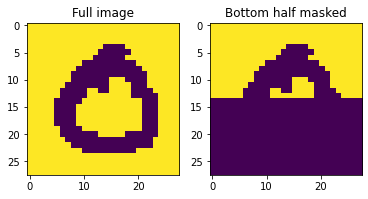

In [ ]:
imgs,labels = trainset[0]
digit = imgs[3,:].reshape(784,1)
digit = binarize(digit)
halved_digit = zero_bottom_half(digit.reshape(28,28)).reshape(784,1)
plt.subplot(1,2,1)
plt.title("Full image")
plt.imshow(digit.reshape(28,28))
plt.subplot(1,2,2)
plt.title("Bottom half masked")
plt.imshow(halved_digit.reshape(28,28))
plt.show()

Finally we get to the classic Hopfield Network which can retrieve a pattern in its list of stored patterns from a partial cue (a half-masked image). Given a vector $\mathbf{X}$ of stored patterns, the Hopfield Network stores them in a weight matrix $\mathbf{W} = \mathbf{X}\mathbf{X}^T$.

To retrieve an item with a probe $z$, we apply the Hopfield Update rule $z^{t+1} = \mathit{sign}(\mathbf{W}z - b)$. Where $b$ is a vector of biases which we ignore (set to 0) here.

It can be shown straightforwardly, that this update rule is the gradient of the Hopfield Energy Function $\mathbf{E} = -\frac{1}{2}z^T \mathbf{w}z + z^Tb$.

Below we demonstrate that retrieval works perfectly when only a single pattern is stored.

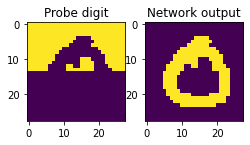

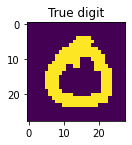

In [ ]:
# Store a single digit in the weights
W = digit @ digit.T
# perform the hopfield update rule with the probe as the halved digit to retrieve the original
out = binarize(W @ halved_digit)

#plot
plt.subplot(1,3,1)
plt.title("Probe digit")
plt.imshow(halved_digit.reshape(28,28))
plt.subplot(1,3,2)
plt.title("Network output")
plt.imshow(out.reshape(28,28))
plt.show()
plt.subplot(1,3,3)
plt.title("True digit")
plt.imshow(out.reshape(28,28))
plt.show()



Now let's test the retrieval capcity of the network when storing multiple digits. When 3 digits are stored we see that retrieval is perfect. (The reconstructions are often flipped, but this is expected behaviour -- since we have no biases, the energy function is symmetrical).

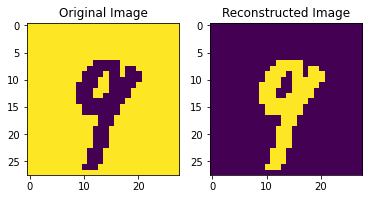

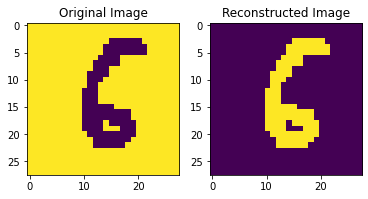

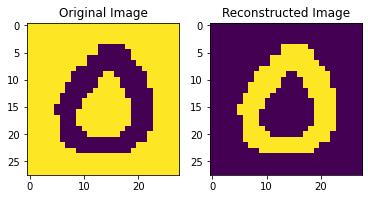

In [ ]:
def store_retrieve_N_images(N):
  # construct weight matrix of N stored images
  W = torch.zeros((784,784))
  for i in range(N):
    digit = binarize(imgs[i,:].reshape(784,1))
    W += digit @ digit.T

  # try to retrieve each image
  for i in range(N):
    digit = binarize(imgs[i,:]).reshape(28,28)
    halved_digit = zero_bottom_half(digit).reshape(784,1)
    out = binarize(W @ halved_digit)
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(digit)
    plt.subplot(1,2,2)
    plt.title("Reconstructed Image")
    plt.imshow(out.reshape(28,28))
    plt.show()

store_retrieve_N_images(3)

However if we store more images, the reconstructions start to fail

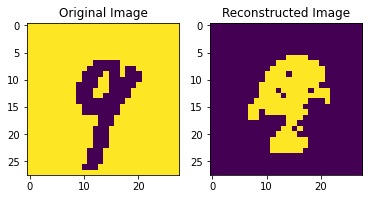

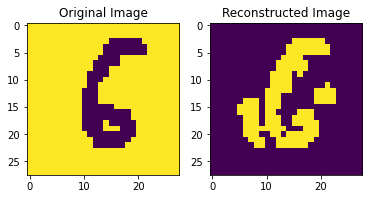

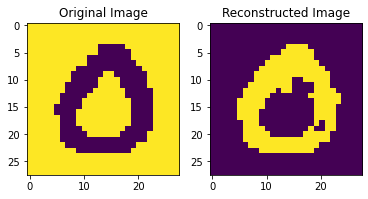

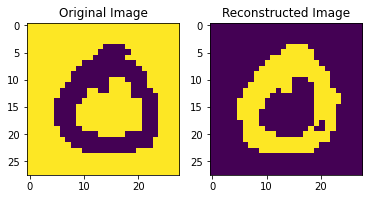

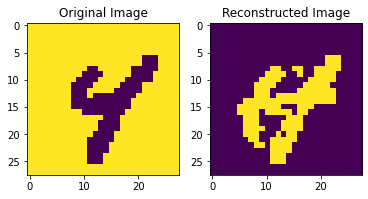

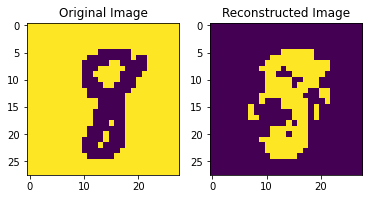

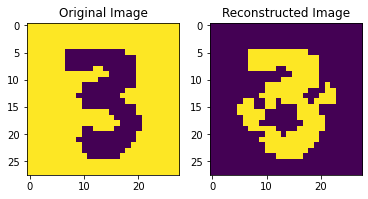

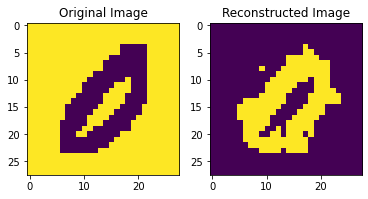

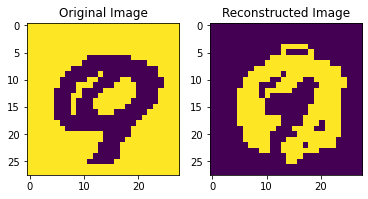

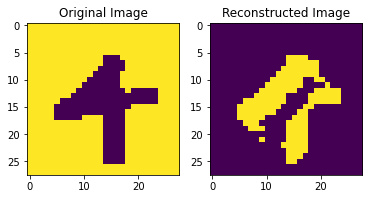

In [ ]:
store_retrieve_N_images(10)

This problem is not due to the storage capacity of the network, which is much greater than 10, but rather because the inputs are correlated.

To alleviate this problem, we can utilize the modern extension of the Hopfield Network pioneered by Krotov and Hopfield (2016) and Demircigil (2017) which allows for dense associative memory.

These networks have the energy function $\mathbf{E} = -exp(\beta^{-1} log (\sum_i exp(\beta x_i^T z))$. Demircigil showed that this energy function can be optimized with a learning rule:
$z^{t+1}[l] = -\mathit{sign}(\mathbf{E}[z[l]^+] + \mathbf{E}[z[l]^-])$

Where $z[l]^+$ is z where the z[l] = +1. In effect, this update rule explicitly enumerates every possible change to the probe z, and determines whether these increase or decrease the energy. If they decrease the energy, they are kept in the output. This rule is, in effect, a combinatorial search over all possible single-edit changes to z to find the one that most minimizes the energy.

Importantly, in this network the stored patterns are no longer stored in a single weight matrix. Instead each pattern is serially compared against the probe, and then all patterns are summed.

In [ ]:
def demircigil_update_rule(z,xs):
  out = torch.zeros(len(z),1)
  # loop over every element of z
  for i in range(len(z)):
    # initialize accumulators for E_positive and E_negative
    E_pos = 0
    E_neg = 0
    # make copies so we don't mutate the original array
    z_pos = deepcopy(z)
    z_neg = deepcopy(z)
    # try both z[l]^+ and z[l]^-
    z_pos[i] = 1
    z_neg[i] = -1
    # for each stored pattern in xs
    for x in xs:
      # compute positive or negative energies
      E_plus = x.T @ z_pos
      E_minus = x.T @ z_neg
      # accumulate their exponents
      E_pos += torch.exp(E_plus/10)
      E_neg += torch.exp(E_minus/10)
    # if energy is greater flip
    if E_pos > E_neg:
      out[i] = 1
    else:
      out[i] = -1
  return out

Although it works, this update rule isn't great for a number of reasons. Firstly, because we are explicitly comparing permutations of z, it's hard to vectorize, and so is slow. Secondly, a naive implementation is numerically unstable due to exponentiating the energies. This often results in nans or infinities. To get it to work I had to divide the computed energies by an arbitrary constant of 10. However there are probably better ways to do this.

Let's test whether this update rule works with a few stored patterns, thus outperforming the classical Hopfield network on memory storage capacity.

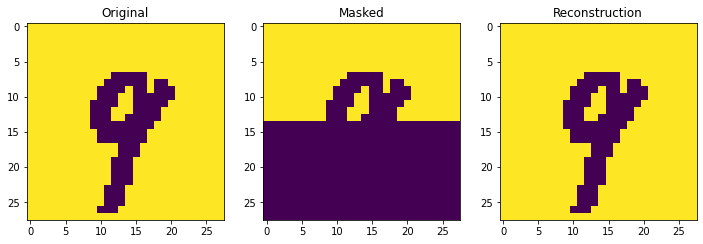

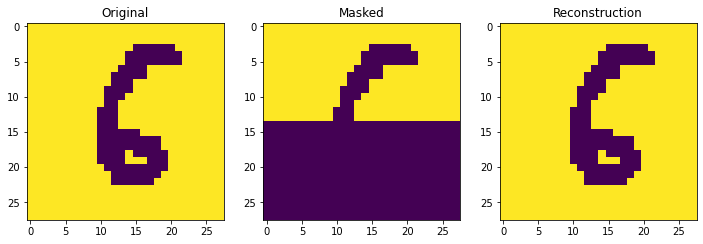

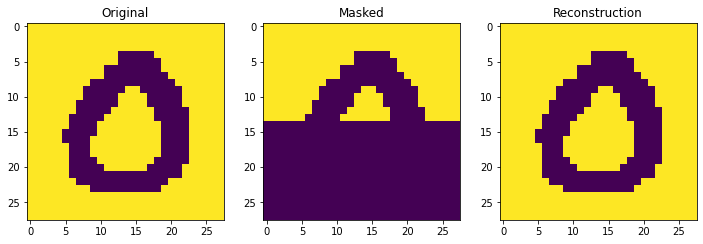

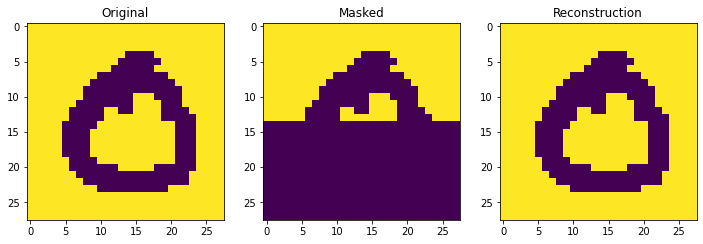

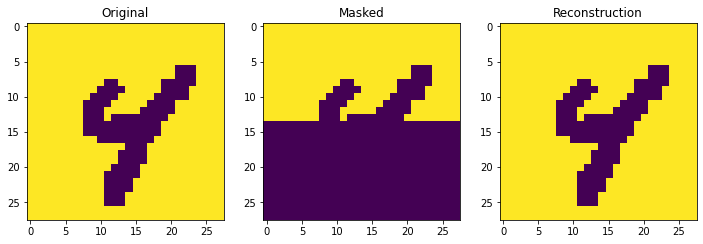

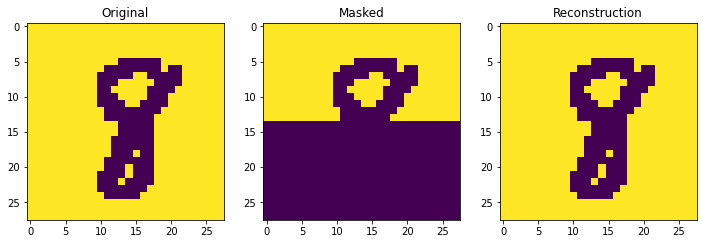

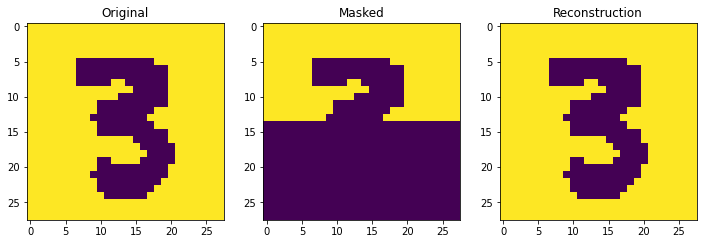

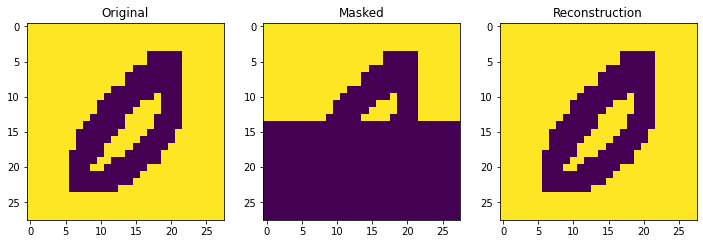

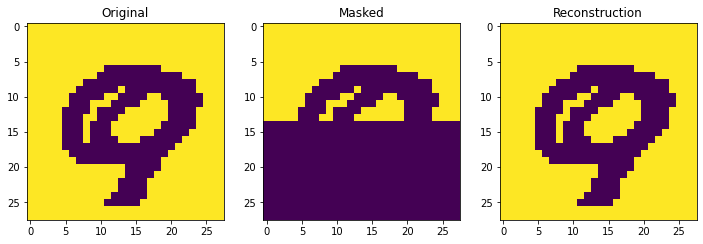

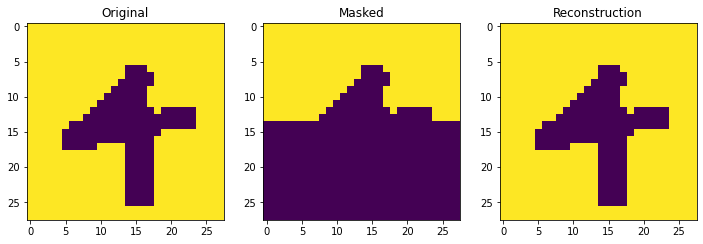

In [ ]:
def retrieve_store_demircigil(imgs,N,break_val=-1):
  xs = [binarize(imgs[i,:].reshape(784,1)) for i in range(N)]
  for j in range(N):
    # so we don't print a huge number of images for large stored patterns
    if break_val >0:
      if j > break_val:
        break
    halved_digit = zero_bottom_half(xs[j]).reshape(784,1)
    out = demircigil_update_rule(halved_digit,xs)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [xs[j], halved_digit, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()


retrieve_store_demircigil(imgs,10)

This network can store 10 patterns without degredation in pattern completion, unlike the classical Hopfield networks. However, perfect retrieval is still limited to far below its theoretical capacity due to correlated patterns. For instance, there are some incorrect retrievals with 100 patterns.

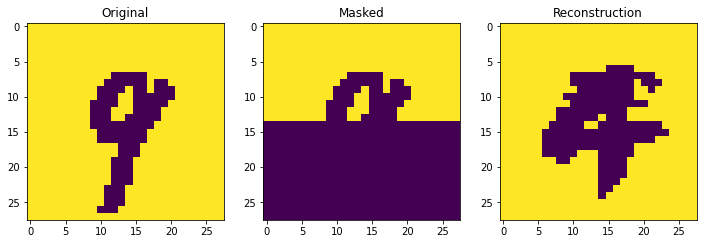

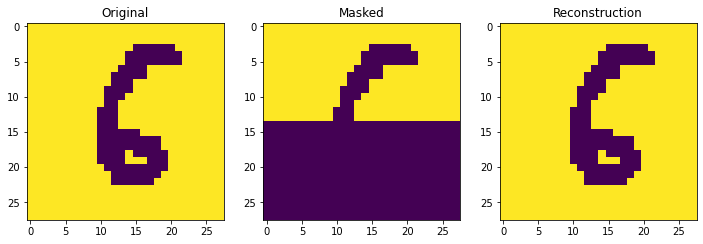

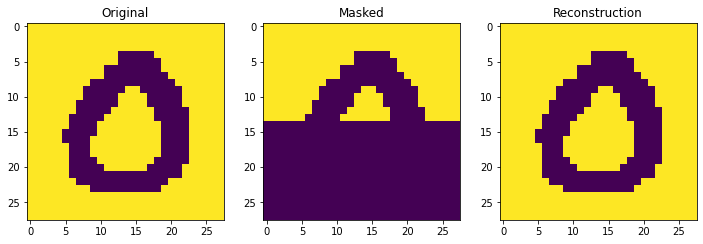

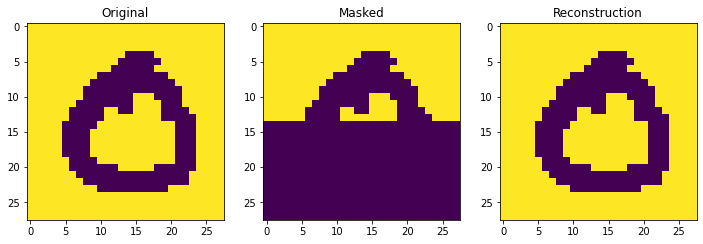

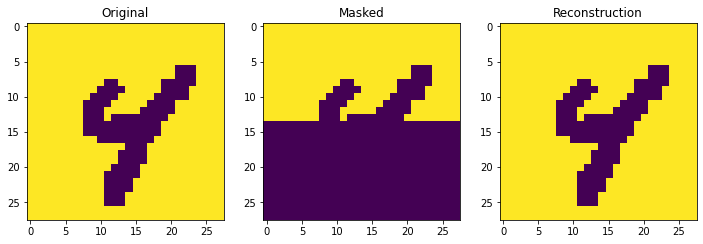

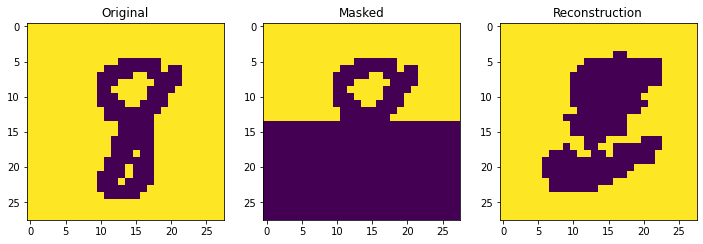

In [ ]:
retrieve_store_demircigil(imgs, 100,5)

# Continuous Modern Hopfield Networks

With our new energy function, the Demircigil Hopfield network has a considerably larger storage capacity than the classical Hopfield network. However, it has one key constraint -- it can only work with binary inputs. We next generalize the energy function to allow for continuous inputs and, as a bonus, we get a much faster vectorizable, update rule which also happens to be very similar to *self-attention*.

Specifically, we define the new continuous energy function as: $\mathbf{E} = -\mathit{log} \sum_i \mathit{exp}(x_i^T z) + z^T z + \beta^{-1} \mathit{log}N$.

Next, we can then use the Concave-Convex-Procedure to obtain an update rule to minimize the energy. This update rule becomes (see blog post for details):

$z^{t+1} = \mathbf{X}^T \sigma(\beta \mathbf{X} z)$

Where $X = (x_1, x_2 \dots x_n)$ is simply a concatenated vector of all stored patterns and $\sigma$ denotes the softmax operator.

This update rule has three extremely powerful properties. It is globally guaranteed to converge to a global minimum of the energy function. 2.) It converges after a single step. and 3.) It grants the network an exponential storage capacity.

First let's simply define some utilities to get continuous (non-binarized) MNIST images as data. Importantly, for continuous images we must now keep everything within the range [0,1] and *not* [-1,1]. We mask out values by setting them to 0.

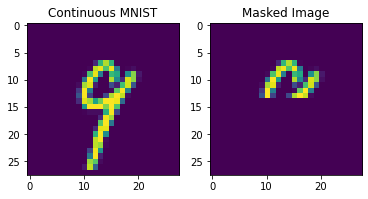

In [ ]:
def halve_continuous_img(img):
  H,W = img.reshape(28,28).shape
  i = deepcopy(img.reshape(28,28))
  i[H//2:H,:] = 0
  return i

xs = [imgs[i,:] for i in range(100)]
plt.subplot(1,2,1)
plt.imshow(xs[0].reshape(28,28))
plt.title("Continuous MNIST")
halved_img = halve_continuous_img(xs[0])
plt.subplot(1,2,2)
plt.title("Masked Image")
plt.imshow(halved_img)
plt.show()


We can see that the continuous Hopfield Network can flawlessly retrieve patterns with 10 stored patterns in memory. Moreover, notice the speed difference between the vectorized continuous update rule, and the non-vectorized demircigil update rule.

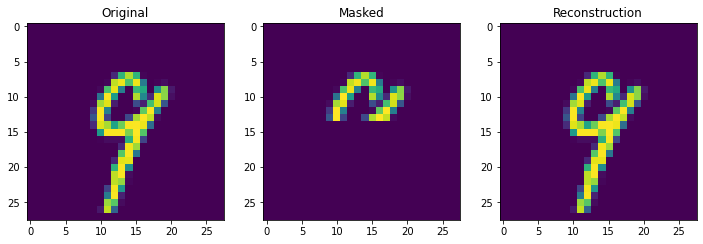

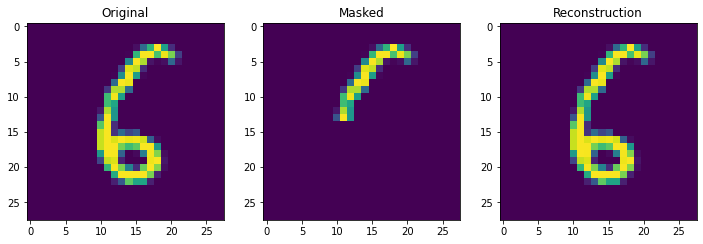

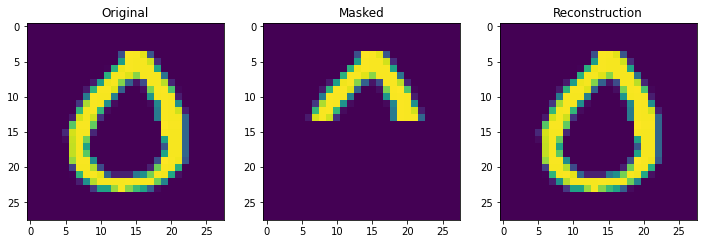

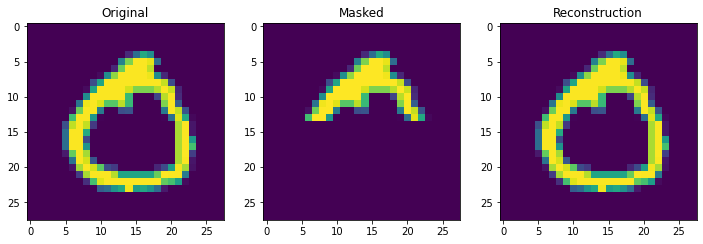

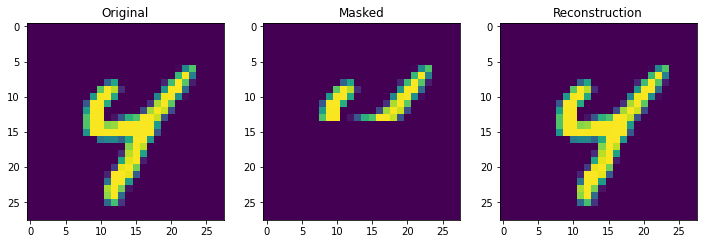

In [ ]:
# we next create our weight matrix and then do update rule to retrieve a half pattern
def continuous_update_rule(X,z,beta):
  return X.T @ F.softmax(beta * X @ z,dim=0)

def retrieve_store_continuous(imgs,N, beta=8,num_plot = 5):
  X = imgs[0:N,:]
  for j in range(num_plot):
    z = halve_continuous_img(X[j,:]).reshape(784,1)
    out = continuous_update_rule(X,z,beta)
    # plot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [X[j,:], z, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()

retrieve_store_continuous(imgs,10)

Next we truly check the storage capcity of the Continuous Hopfield Network. With 100 updates there is 1 mistake, but little other sign of degredation.

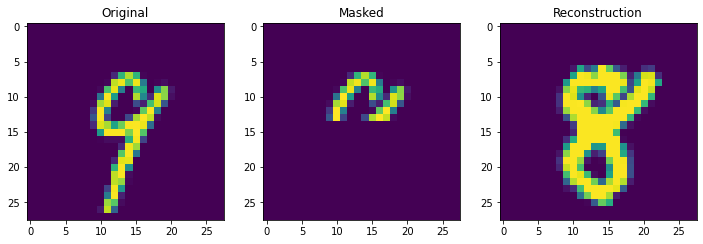

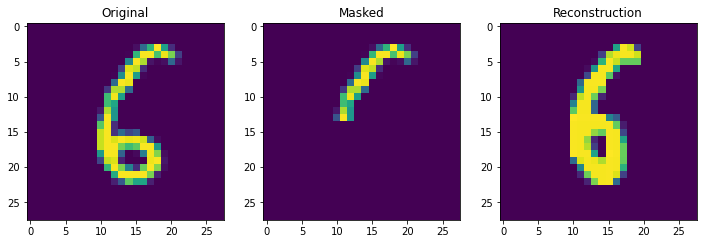

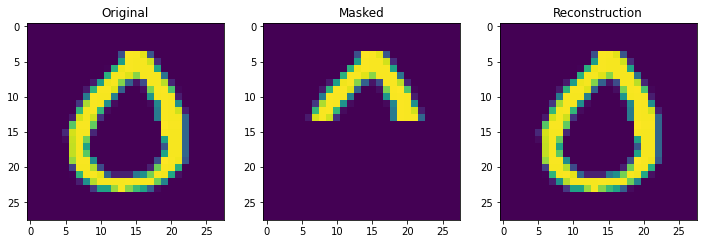

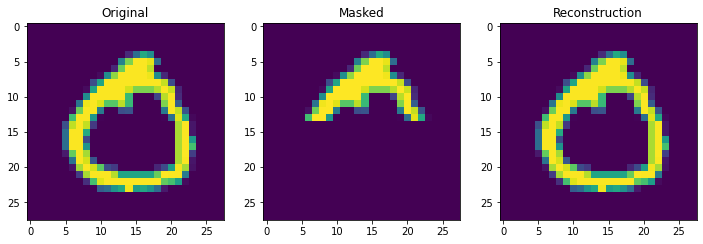

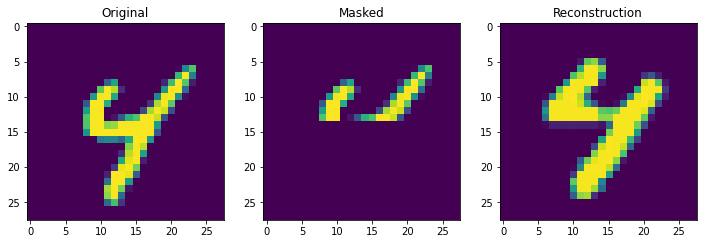

In [ ]:
retrieve_store_continuous(imgs, 100)

With 1000 stored patterns, there is more signs of degredation and several wrong answers. It is clear overall that it is not the theoretical storage capacity (exponential in this case) that matters but the ability to pull apart correlated inputs, which is still not perfect even in the modern continuous case.

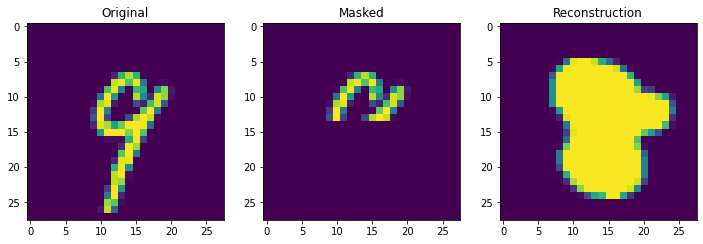

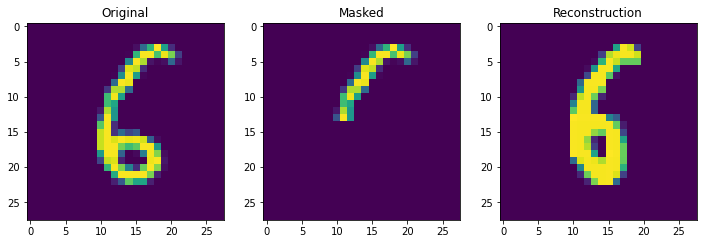

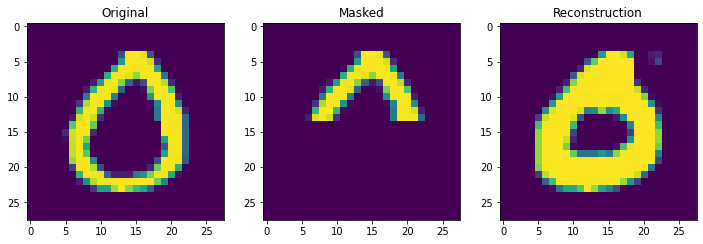

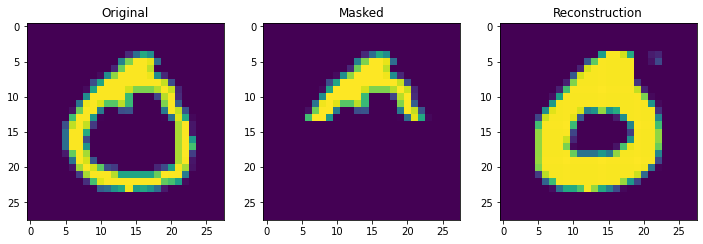

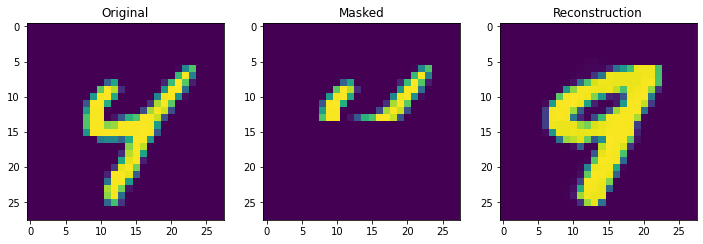

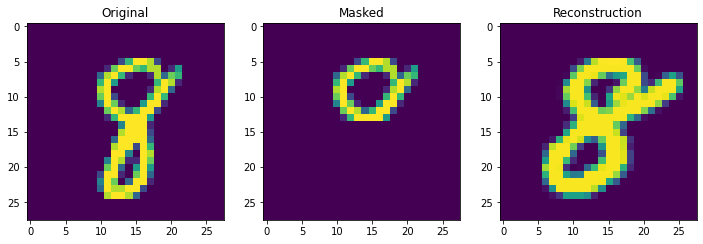

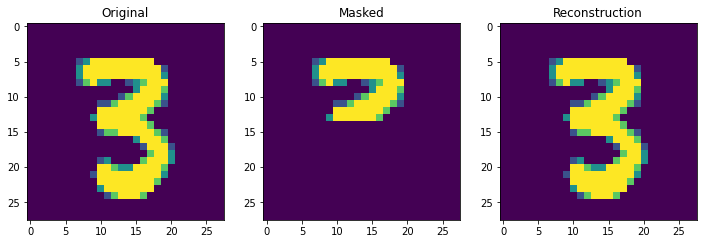

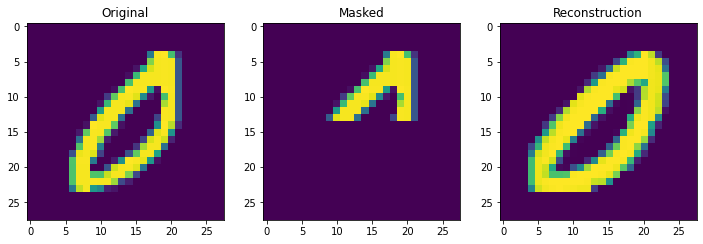

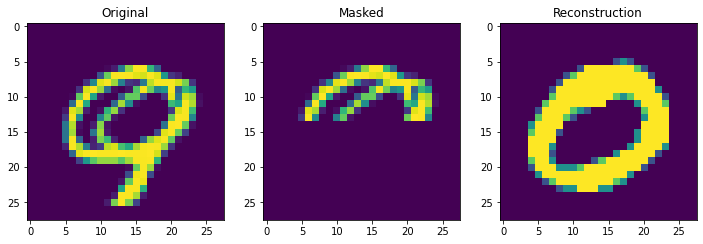

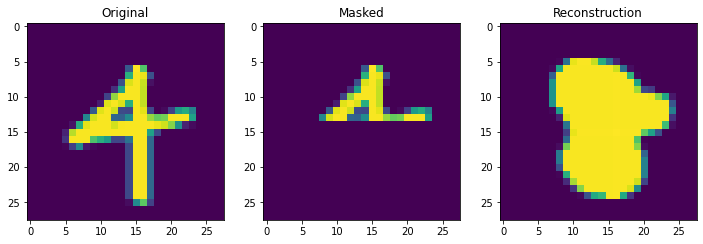

In [ ]:
retrieve_store_continuous(imgs, 1000, num_plot=10)

One final thing we can do is check the effects of the $\beta$ parameter. We find that increasing $\beta$ effectively determines the sharpness of the energy landscape. With low $\beta$ there are many metastable local attractors which do not correspond to a stored pattern. These metastable attractors typically end up looking like a smeared-out average of multiple patterns. On the other hand when $\beta$ is large, then the energy landscape is very steep, and the only attractors are those corresponding to real stored patterns.

We can visualize this effect directly by varying beta and comparing the reconstructed results.

Beta:  0.1


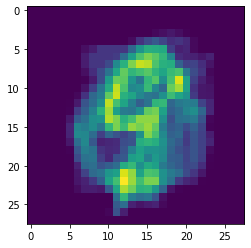

Beta:  0.2


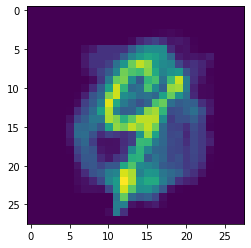

Beta:  0.5


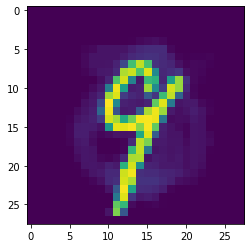

Beta:  1


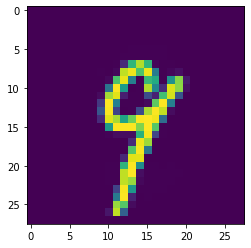

Beta:  2


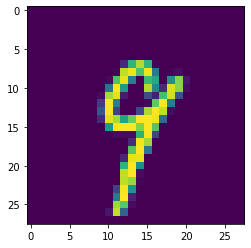

Beta:  4


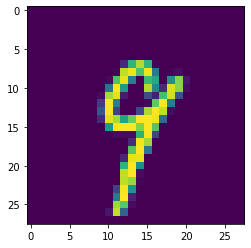

Beta:  8


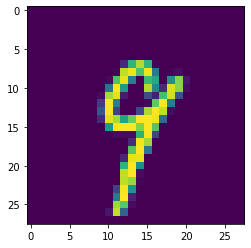

In [ ]:
# check effects of beta
betas = [0.1,0.2,0.5,1,2,4,8]
X = imgs[0:10,:]
z = halve_continuous_img(X[0,:]).reshape(784,1)
for beta in betas:
  print("Beta: ", beta)
  out = continuous_update_rule(X,z,beta)
  out = out.reshape(28,28)
  plt.imshow(out)
  plt.show()
